In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Charger la dataset
file_path = "SWaT_Dataset_Attack_v0.csv"
df = pd.read_csv(file_path)

     FIT101    LIT101   MV101  P101  P102    AIT201    AIT202    AIT203  \
0  2.427057  522.8467       2     2     1  262.0161  8.396437  328.6337   
1  2.446274  522.8860       2     2     1  262.0161  8.396437  328.6337   
2  2.489191  522.8467       2     2     1  262.0161  8.394514  328.6337   
3  2.534350  522.9645       2     2     1  262.0161  8.394514  328.6337   
4  2.569260  523.4748       2     2     1  262.0161  8.394514  328.6337   

     FIT201   MV201  ...  P501  P502    PIT501    PIT502    PIT503    FIT601  \
0  2.445391       2  ...     2     1  250.8652  1.649953  189.5988  0.000128   
1  2.445391       2  ...     2     1  250.8652  1.649953  189.6789  0.000128   
2  2.442316       2  ...     2     1  250.8812  1.649953  189.6789  0.000128   
3  2.442316       2  ...     2     1  250.8812  1.649953  189.6148  0.000128   
4  2.443085       2  ...     2     1  250.8812  1.649953  189.5027  0.000128   

   P601  P602  P603  Normal/Attack  
0     1     1     1         Nor

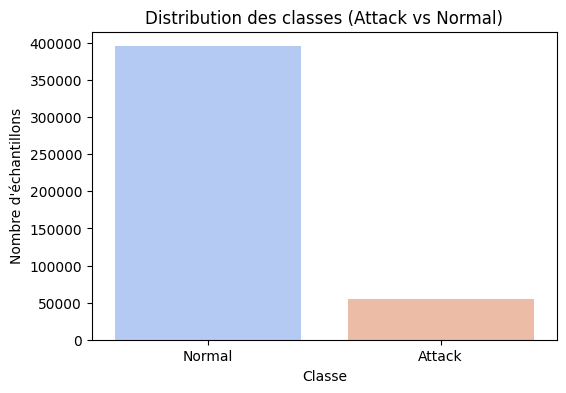

In [3]:
# Afficher un aperçu
print(df.head())

# Nombre de colonnes
print(f"Nombre de colonnes : {df.shape[1]}")

# Vérifier la distribution des classes
print(df.iloc[:, -1].value_counts())  # Dernière colonne = label (Attack/Normal)

# Graphique de la distribution des classes (Correction warning)
plt.figure(figsize=(6, 4))
sns.countplot(x=df.iloc[:, -1], hue=df.iloc[:, -1], palette="coolwarm", legend=False)
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes (Attack vs Normal)")
plt.show()

In [4]:
# Séparation des features (X) et des labels (y)
X = df.iloc[:, :-1].values  # Toutes les colonnes sauf la dernière (features)
y = df.iloc[:, -1].values   # La dernière colonne (label)

# Encoder les labels: "Normal" -> 0, "Attack" -> 1
y = np.where(y == "Normal", 0, 1)

In [5]:
# Diviser en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convertir en tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Créer DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [6]:
# Définir l'architecture du modèle
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden2, hidden3),
            nn.BatchNorm1d(hidden3),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden3, 2)  # 2 classes: Normal (0) et Attack (1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Hyperparamètres
input_size = X_train.shape[1]  # Nombre de features
hidden1 = 256
hidden2 = 128
hidden3 = 64
learning_rate = 0.001
num_epochs = 10
patience = 5  # Pour l'early stopping

In [8]:
# Initialiser le modèle, la perte et l'optimiseur
model = MLP(input_size, hidden1, hidden2, hidden3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Historique des pertes et des précisions
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [9]:
# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model, "best_model_full.pt")  # Sauvegarde du modèle complet
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break

Epoch [1/10], Train Loss: 0.0963, Train Accuracy: 0.9749, Val Loss: 0.0695, Val Accuracy: 0.9795
Epoch [2/10], Train Loss: 0.0680, Train Accuracy: 0.9821, Val Loss: 0.0447, Val Accuracy: 0.9871
Epoch [3/10], Train Loss: 0.0599, Train Accuracy: 0.9840, Val Loss: 0.0397, Val Accuracy: 0.9878
Epoch [4/10], Train Loss: 0.0548, Train Accuracy: 0.9850, Val Loss: 0.0360, Val Accuracy: 0.9891
Epoch [5/10], Train Loss: 0.0515, Train Accuracy: 0.9858, Val Loss: 0.0361, Val Accuracy: 0.9882
Epoch [6/10], Train Loss: 0.0487, Train Accuracy: 0.9863, Val Loss: 0.0330, Val Accuracy: 0.9895
Epoch [7/10], Train Loss: 0.0468, Train Accuracy: 0.9867, Val Loss: 0.0325, Val Accuracy: 0.9893
Epoch [8/10], Train Loss: 0.0447, Train Accuracy: 0.9871, Val Loss: 0.0319, Val Accuracy: 0.9893
Epoch [9/10], Train Loss: 0.0439, Train Accuracy: 0.9871, Val Loss: 0.0283, Val Accuracy: 0.9902
Epoch [10/10], Train Loss: 0.0433, Train Accuracy: 0.9874, Val Loss: 0.0329, Val Accuracy: 0.9902


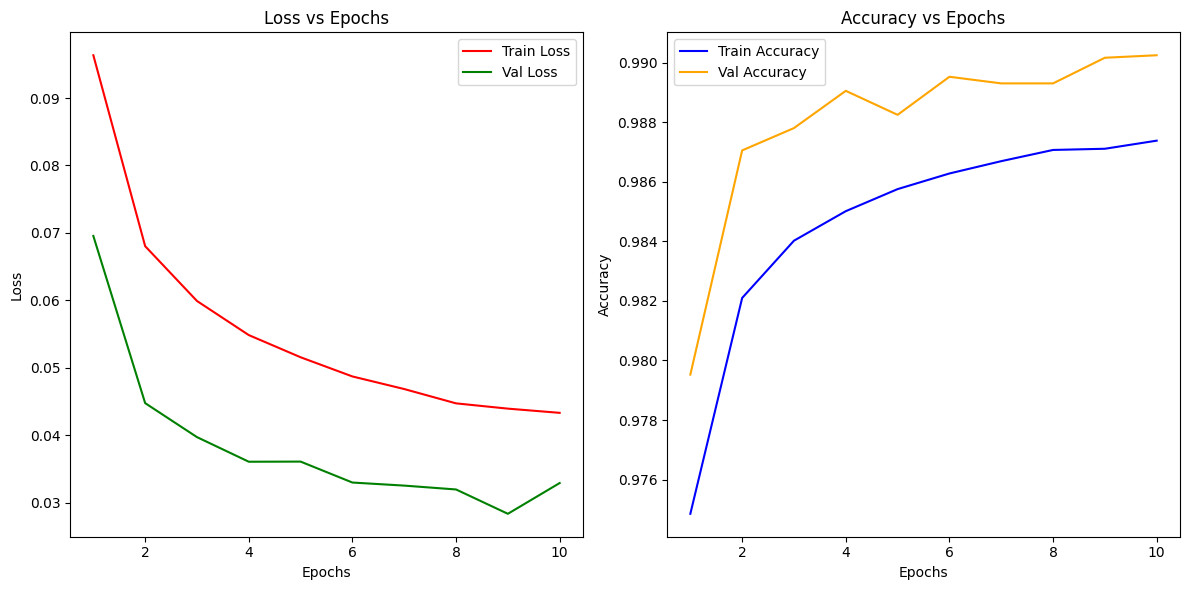

In [10]:
# Affichage des courbes de perte et de précision
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="red")
plt.plot(epochs, val_losses, label="Val Loss", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
plt.plot(epochs, val_accuracies, label="Val Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Évaluation sur l'ensemble de test
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9899


In [12]:
# Sauvegarde uniquement des poids du modèle
torch.save(model.state_dict(), "swat_mlp.pt")
print("Poids du modèle sauvegardés sous le nom 'swat_mlp.pt'")

Poids du modèle sauvegardés sous le nom 'swat_mlp.pt'
